In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
NUM_WORKERS = 4

In [2]:
DATA_PATH = "/kaggle/input/ventilator-pressure-prediction/"

sub = pd.read_csv(DATA_PATH + 'sample_submission.csv')
df_train = pd.read_csv(DATA_PATH + 'train.csv')
df_test = pd.read_csv(DATA_PATH + 'test.csv')

In [3]:
print(len(df_train))
df_train[20:40]

6036000


,id,breath_id,R,C,time_step,u_in,u_out,pressure
20,21,1,20,50,0.680176,20.701046,0,19.335504
21,22,1,20,50,0.715327,20.843610,0,18.491878
22,23,1,20,50,0.749344,20.269191,0,18.562180
23,24,1,20,50,0.783241,19.693681,0,18.632482
24,25,1,20,50,0.817397,18.927285,0,18.843389
25,26,1,20,50,0.851411,18.093826,0,19.054295
26,27,1,20,50,0.885488,17.193955,0,19.265201
27,28,1,20,50,0.919468,16.419253,0,19.335504
28,29,1,20,50,0.953547,15.744684,0,19.335504
29,30,1,20,50,0.987487,14.931596,0,19.476108


In [4]:
df_test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [5]:
df_train["breath_id"].unique()

array([     1,      2,      3, ..., 125743, 125745, 125749])

In [6]:
def plot_data(df, breath_id):
    df_breath = df[df["breath_id"] == breath_id]
    r, c = df_breath[["R", "C"]].values[0]
    plt.figure(figsize=(12, 4))
    for col in ["u_in", "u_out", "pressure"]:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
    plt.legend()
    plt.title(f'breath_id: {breath_id} R: {r} C: {c}')

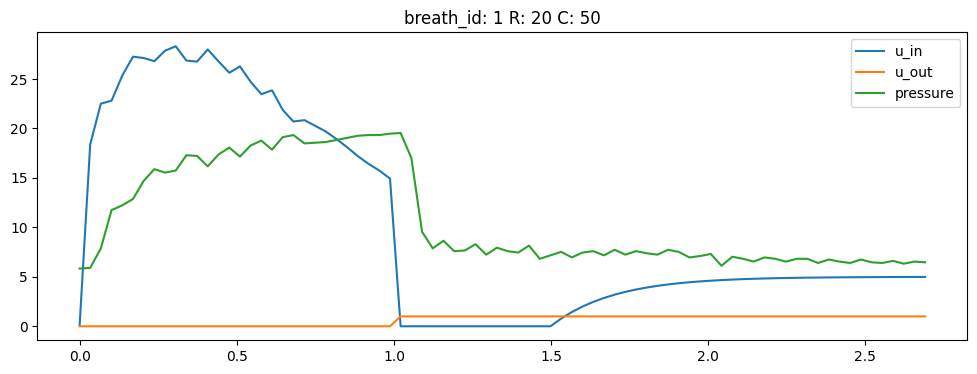

In [7]:
plot_data(df_train , 1)

In [8]:
import torch
from torch.utils.data import Dataset

class VentilatorDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df.groupby("breath_id").agg(list).reset_index()
        self.prepare_data()

    def __len__(self):
        return self.df.shape[0]
        
    def prepare_data(self):
        self.pressures = np.array(self.df['pressure'].values.tolist())
        rs = np.array(self.df['R'].values.tolist())
        cs = np.array(self.df['C'].values.tolist())
        u_ins = np.array(self.df['u_in'].values.tolist())
        self.u_outs = np.array(self.df['u_out'].values.tolist())
        
        self.inputs = np.concatenate([
            rs[:, None], 
            cs[:, None], 
            u_ins[:, None], 
            np.cumsum(u_ins, 1)[:, None],
            self.u_outs[:, None]
        ], 1).transpose(0, 2, 1)

    def __getitem__(self, idx):
        data = {
            "input": torch.tensor(self.inputs[idx], dtype=torch.float),
            "u_out": torch.tensor(self.u_outs[idx], dtype=torch.float),
            "p": torch.tensor(self.pressures[idx], dtype=torch.float),
        }
        
        return data

In [9]:
dataset = VentilatorDataset(df_train)
print(dataset[0]["input"].shape)
dataset[0]

torch.Size([80, 5])


{'input': tensor([[2.0000e+01, 5.0000e+01, 8.3334e-02, 8.3334e-02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 1.8383e+01, 1.8466e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2509e+01, 4.0976e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.2809e+01, 6.3784e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.5356e+01, 8.9140e+01, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7260e+01, 1.1640e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7127e+01, 1.4353e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6808e+01, 1.7034e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7865e+01, 1.9820e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.8313e+01, 2.2651e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6867e+01, 2.5338e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6763e+01, 2.8014e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.7993e+01, 3.0814e+02, 0.0000e+00],
         [2.0000e+01, 5.0000e+01, 2.6790e+01, 3.3493e+02, 0.0000e+00

In [10]:
a = [np.arange(10)]
b = [np.arange(10) * 2] 
c = [np.arange(10) * 3]
d = [np.arange(10) * 4]

print(a)
e = np.concatenate([
    a,b,c,d
],0)
e

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]])

In [11]:
e.transpose(1, 0)

array([[ 0,  0,  0,  0],
       [ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12],
       [ 4,  8, 12, 16],
       [ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28],
       [ 8, 16, 24, 32],
       [ 9, 18, 27, 36]])

# LSTM

In [12]:
import torch
import torch.nn as nn
import math


class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim
        # Update gate
        self.w_ux = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_ua = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_u = nn.Parameter(torch.Tensor(output_dim, 1))

        # Forget gate
        self.w_fx = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_fa = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_f = nn.Parameter(torch.Tensor(output_dim, 1))

        # Output gate
        self.w_ox = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_oa = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_o = nn.Parameter(torch.Tensor(output_dim, 1))

        # Potential next candidate
        self.w_cx = nn.Parameter(torch.Tensor(input_dim, output_dim)) 
        self.w_ca = nn.Parameter(torch.Tensor(output_dim, output_dim)) 
        self.b_c = nn.Parameter(torch.Tensor(output_dim, 1))

        # Initialize parameters for better performance
        self.reset_parameters()

    def reset_parameters(self):
        # A common way to initialize weights, similar to what nn.Linear does
        stdv = 1.0 / math.sqrt(self.output_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, X):
        seq_len = X.shape[0]
        hidden_candidate_state = torch.zeros((seq_len, self.output_dim, 1))
        hidden_activation_state = torch.zeros((seq_len, self.output_dim, 1))
        curr_candidate = torch.zeros((self.output_dim, 1))
        curr_activation = torch.zeros((self.output_dim, 1))
        for i in range(seq_len):
            curr_input = X[i]
            update_gate = torch.sigmoid((self.w_ux.T @ curr_input) + (self.w_ua.T @ curr_activation) + self.b_u)
            output_gate = torch.sigmoid((self.w_ox.T @ curr_input) + (self.w_oa.T @ curr_activation) + self.b_o)
            forget_gate = torch.sigmoid((self.w_fx.T @ curr_input) + (self.w_fa.T @ curr_activation) + self.b_f)

            potential_new_candidate = torch.tanh((self.w_cx.T @ curr_input) + (self.w_ca.T @ curr_activation) + self.b_u)
            next_candidate = (update_gate * potential_new_candidate) + (forget_gate * curr_candidate)
            next_activation = output_gate * torch.tanh(next_candidate)
            hidden_candidate_state[i] = next_candidate
            hidden_activation_state[i] = next_activation
            curr_candidate = next_candidate
            curr_activation = next_activation

        return hidden_activation_state
            
        


In [13]:
lstm = LSTM(10, 20)
a = torch.randn(5,10, 1)
lstm(a).shape

torch.Size([5, 20, 1])